# Sobreajuste (overfitting)

## Introducción

### Árboles de Decisión y sobreajuste

Los Árboles de Decisión pueden ser muchas veces una herramienta muy precisa, pero también con mucha tendencia al sobreajuste. Para construir estos modelos aplicamos un procedimiento recursivo para encontrar los atributos que nos proporcionan más información sobre distintos subconjuntos de datos, cada vez más pequeños. Si aplicamos este procedimiento en forma reiterada, eventualmente podemos llegar a un árbol en el que cada *hoja* tenga una sola instancia de nuestra variable objetivo a clasificar. En este caso extremo, el Árbol de Decisión va a tener una pobre *generalización* y estar bastante sobreajustado; ya que cada instancia de los datos de entrenamiento va a encontrar el camino que lo lleve eventualmente a la hoja que lo contiene, alcanzando así una precisión del 100% con los datos de entrenamiento. Veamos un ejemplo sencillo con la ayuda de Python.

In [42]:
# <!-- collapse=True -->
# Importando las librerías que vamos a utilizar
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import random; random.seed(1982)

# graficos incrustados
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})

In [43]:
# dummy data con 200 atributos y 2 clases
X, y = make_classification(1000, 200, n_informative=3, n_classes=2,
                          random_state=1982)

#El parámetro n_informative en la función make_classification de sklearn.datasets
#especifica el número de características informativas que tendrán un impacto directo en la clasificación de las clases objetivo (y).

# separ los datos en train y eval
x_train, x_eval, y_train, y_eval = train_test_split(X, y, test_size=0.35, 
                                                    train_size=0.65,
                                                    random_state=1983)

# creando el modelo sin control de profundidad, va a continuar hasta
# que todas las hojas sean puras
arbol = DecisionTreeClassifier(criterion='entropy', random_state=10)

# Ajustando el modelo
arbol.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=10)

In [44]:
# precisión del modelo en datos de entrenamiento.
print("precisión entranamiento: {0: .2f}".format(
        arbol.score(x_train, y_train)))

precisión entranamiento:  1.00


Logramos una precisión del 100 %, increíble...

Veamos como se comporta con los datos de evaluación.

In [45]:
# precisión del modelo en datos de evaluación.
print("precisión evaluación: {0: .2f}".format(
        arbol.score(x_eval, y_eval)))

precisión evaluación:  0.88


Ah, ahora nuestro modelo ya no se muestra tan preciso, esto se debe a que seguramente esta sobreajustado, ya que dejamos crecer el árbol hasta que cada hoja estuviera pura (es decir que solo contenga datos de una sola de las clases a predecir). Una alternativa para reducir el sobreajuste y ver si podemos lograr que *generalice* mejor y por tanto tenga más precisión para datos nunca vistos, es tratar de reducir la complejidad del modelo por medio de controlar la profundidad que puede alcanzar el árbol

In [46]:
# profundidad del arbol de decisión.
arbol.tree_.max_depth

9

Pongamos un máximo de profundidad de tan solo 5 nodos.

In [48]:
# modelo dos, con control de profundiad de 5 nodos
arbol2 = DecisionTreeClassifier(criterion='entropy', max_depth=5)

# Ajustando el modelo
arbol2.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [49]:
# precisión del modelo en datos de entrenamiento.
print("precisión entranamiento: {0: .2f}".format(
        arbol2.score(x_train, y_train)))

precisión entranamiento:  0.96


Ahora podemos ver que ya no tenemos un modelo con 100% de precisión en los datos de entrenamiento, sino que la precisión es inferior, 96%, sin embargo si ahora medimos la precisión con los datos de evaluación vemos que la precisión es del 91%

In [50]:
# precisión del modelo en datos de evaluación.
print("precisión evaluación: {0: .2f}".format(
        arbol2.score(x_eval, y_eval)))

precisión evaluación:  0.90


**Esta diferencia se debe a que redujimos la complejidad del modelo para intentar ganar en generalización**. También debemos tener en cuenta que si seguimos reduciendo la complejidad, podemos crear un modelo demasiado simple que en vez de estar sobreajustado puede tener un desempeño muy por debajo del que podría tener; podríamos decir que el modelo estaría *subajustado* y tendría un alto nivel de *sesgo*.

Para ayudarnos a encontrar el término medio entre la complejidad del modelo y su *ajuste* a los datos, podemos ayudarnos de herramientas gráficas. Por ejemplo podríamos crear diferentes modelos, con distintos grados de complejidad y luego graficar la precisión en función de la complejidad.

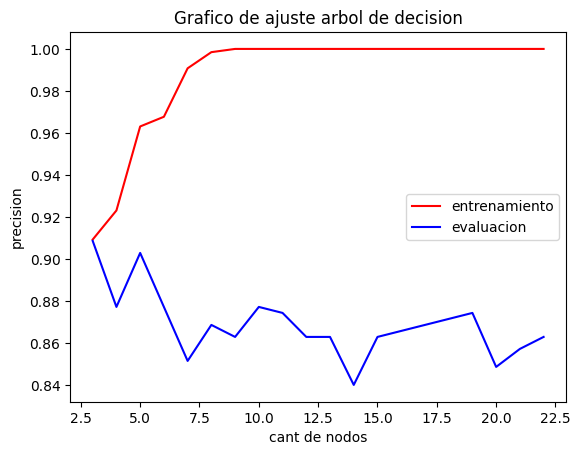

In [51]:
# Grafico de ajuste del árbol de decisión
train_prec =  []
eval_prec = []
max_deep_list = list(range(3, 23))

for deep in max_deep_list:
    arbol3 = DecisionTreeClassifier(criterion='entropy', max_depth=deep)
    arbol3.fit(x_train, y_train)
    train_prec.append(arbol3.score(x_train, y_train))
    eval_prec.append(arbol3.score(x_eval, y_eval))

# graficar los resultados.
plt.plot(max_deep_list, train_prec, color='r', label='entrenamiento')
plt.plot(max_deep_list, eval_prec, color='b', label='evaluacion')
plt.title('Grafico de ajuste arbol de decision')
plt.legend()
plt.ylabel('precision')
plt.xlabel('cant de nodos')
plt.show()

El gráfico que acabamos de construir se llama *gráfico de ajuste* y muestra la precisión del modelo en función de su complejidad. En nuestro ejemplo, podemos ver que el punto con mayor precisión, en los datos de evaluación, lo obtenemos con un nivel de profundidad de aproximadamente 6 nodos; a partir de allí el modelo pierde en *generalización* y comienza a estar sobreajustado. También podemos crear un gráfico similar con la ayuda de [Scikit-learn](http://scikit-learn.org/stable/), utilizando `validation_curve`.

In [52]:
# utilizando validation curve de sklearn
from sklearn.model_selection import validation_curve

train_prec, eval_prec = validation_curve(estimator=arbol, X=x_train,
                                        y=y_train, param_name='max_depth',
                                        param_range=max_deep_list, cv=5)

train_mean = np.mean(train_prec, axis=1)
train_std = np.std(train_prec, axis=1)
test_mean = np.mean(eval_prec, axis=1)
test_std = np.std(eval_prec, axis=1)

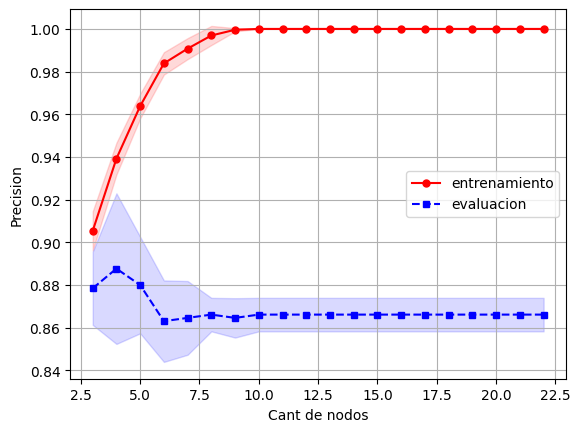

In [53]:
# graficando las curvas
plt.plot(max_deep_list, train_mean, color='r', marker='o', markersize=5,
         label='entrenamiento')
plt.fill_between(max_deep_list, train_mean + train_std, 
                 train_mean - train_std, alpha=0.15, color='r')
plt.plot(max_deep_list, test_mean, color='b', linestyle='--', 
         marker='s', markersize=5, label='evaluacion')
plt.fill_between(max_deep_list, test_mean + test_std, 
                 test_mean - test_std, alpha=0.15, color='b')
plt.grid()
plt.legend(loc='center right')
plt.xlabel('Cant de nodos')
plt.ylabel('Precision')
plt.show()

En este gráfico, también podemos ver que nuestro modelo tiene bastante *varianza*, representada por el área esfumada.

## Métodos para reducir el Sobreajuste

Algunas de las técnicas que podemos utilizar para reducir el sobreajuste, son:

* Utilizar *validación cruzada*.
* Recolectar más datos.
* Introducir una penalización a la complejidad con alguna técnica de regularización.
* Optimizar los parámetros del modelo con *grid search*.
* Reducir la dimensión de los datos.
* Aplicar técnicas de selección de atributos.
* Utilizar modelos *ensamblados*.

Veamos algunos ejemplos.

### Validación cruzada

La *validación cruzada* se inicia mediante el fraccionamiento de un conjunto de datos) en un número $k$ de particiones (generalmente entre 5 y 10) llamadas *pliegues*. La *validación cruzada* luego itera entre los datos de *evaluación* y *entrenamiento* $k$ veces, de un modo particular. En cada iteración de la *validación cruzada*, un *pliegue* diferente se elige como los datos de *evaluación*. En esta iteración, los otros *pliegues* $k-1$ se combinan para formar los datos de *entrenamiento*. Por lo tanto, en cada iteración tenemos $(k-1) / k$ de los datos utilizados para el *entrenamiento* y $1 / k$ utilizado para la *evaluación*.
Cada iteración produce un modelo, y por lo tanto una estimación del rendimiento de la *generalización*, por ejemplo, una estimación de la precisión. Una vez finalizada la *validación cruzada*, todos los ejemplos se han utilizado sólo una vez para *evaluar* pero $k -1$ veces para *entrenar*. En este punto tenemos estimaciones de rendimiento de todos los *pliegues* y podemos calcular la media y la desviación estándar de la precisión del modelo. Veamos un ejemplo

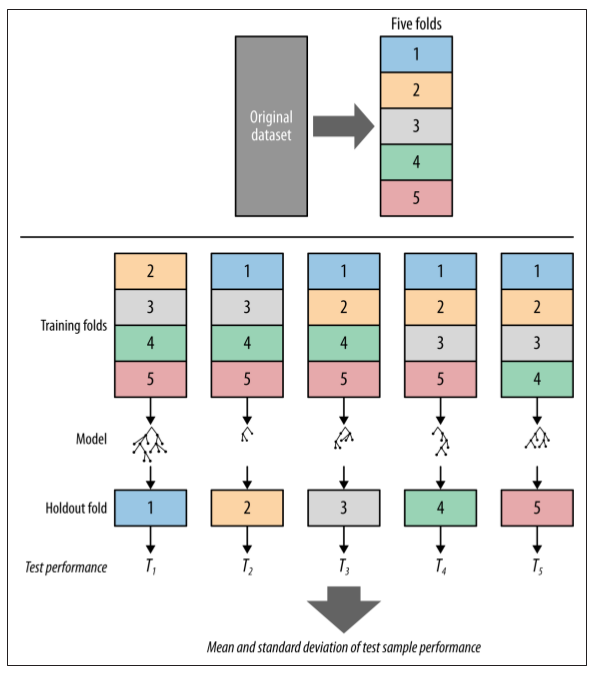

In [54]:
# Ejemplo cross-validation
from sklearn.model_selection import StratifiedKFold

# creando pliegues
kfold = StratifiedKFold(n_splits=10)
kpliegues=kfold.split(X, y)
# iterando entre los plieges
precision = []
for k, (train, test) in enumerate(kpliegues):
    arbol2.fit(X[train], y[train]) 
    score = arbol2.score(X[test], y[test])
    precision.append(score)
    print('Pliegue: {0:}, Dist Clase: {1:}, Prec: {2:.3f}'.format(k+1, np.bincount(y[train]), score))

# imprimir promedio y desvio estandar
print('Precision promedio: {0: .3f} +/- {1: .3f}'.format(np.mean(precision),
                                          np.std(precision)))

Pliegue: 1, Dist Clase: [449 451], Prec: 0.910
Pliegue: 2, Dist Clase: [449 451], Prec: 0.900
Pliegue: 3, Dist Clase: [448 452], Prec: 0.890
Pliegue: 4, Dist Clase: [448 452], Prec: 0.930
Pliegue: 5, Dist Clase: [448 452], Prec: 0.920
Pliegue: 6, Dist Clase: [448 452], Prec: 0.940
Pliegue: 7, Dist Clase: [448 452], Prec: 0.860
Pliegue: 8, Dist Clase: [448 452], Prec: 0.870
Pliegue: 9, Dist Clase: [448 452], Prec: 0.910
Pliegue: 10, Dist Clase: [448 452], Prec: 0.840
Precision promedio:  0.897 +/-  0.030


En este ejemplo, utilizamos el objeto `StratifiedKFold` que nos proporciona Scikit-learn. Es una versión mejorada de la *validación cruzada*, ya que cada *pliegue* va a estar estratificado para mantener las proporciones entre las *clases* del conjunto de datos original, lo que suele dar mejores estimaciones del sesgo y la varianza del modelo. También podríamos utilizar `cross_val_score` que ya nos proporciona los resultados de la precisión que tuvo el modelo en cada *pliegue*.

In [55]:
# Ejemplo con cross_val_score
from sklearn.model_selection import cross_val_score

precision = cross_val_score(estimator=arbol2,
                                            X=x_train, y=y_train,
                                            cv=10, n_jobs=-1)

'precisiones: {}'.format(precision)
print('Precision promedio: {0: .3f} +/- {1: .3f}'.format(np.mean(precision),
                                          np.std(precision)))

Precision promedio:  0.871 +/-  0.042


### Más datos y curvas de aprendizaje

Muchas veces, reducir el sobreajuste es tan fácil como conseguir más datos, dame más datos y te predeciré el futuro!. Aunque en la vida real nunca es una tarea tan sencilla conseguir más datos. Otra herramienta analítica que nos ayuda a entender como reducimos el sobreajuste con la ayuda de más datos, son las *curvas de aprendizaje*, las cuales grafican la precisión en función del tamaño de los datos de entrenamiento. 


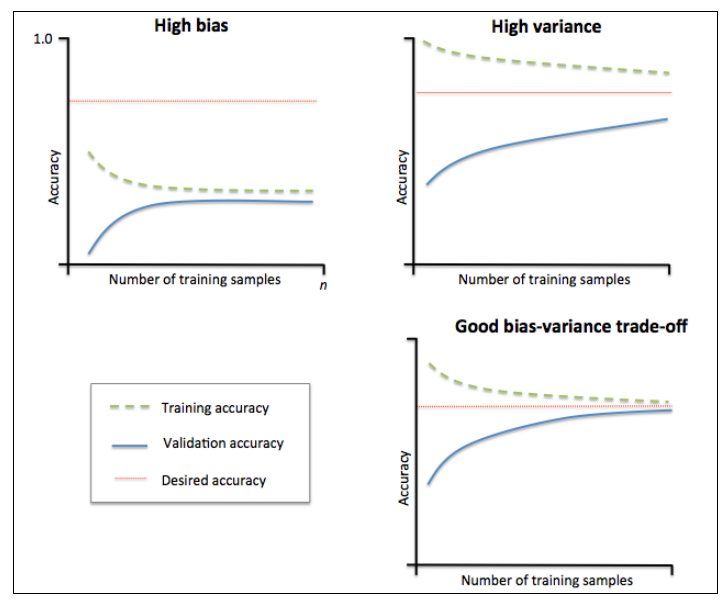

In [56]:
# Ejemplo Curvas de aprendizaje
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=arbol2,
                        X=x_train, y=y_train, 
                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10,
                        n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

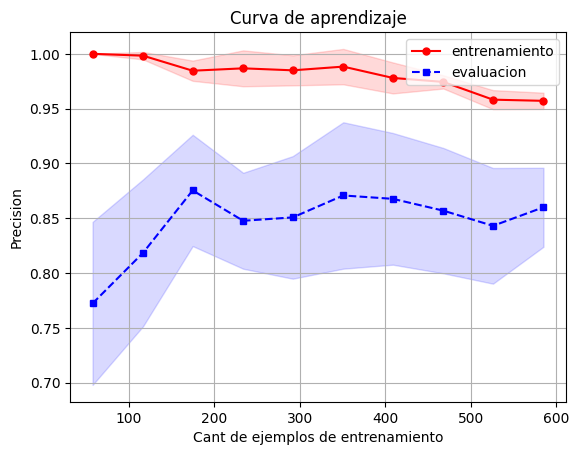

In [57]:
# graficando las curvas
plt.plot(train_sizes, train_mean, color='r', marker='o', markersize=5,
         label='entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, 
                 train_mean - train_std, alpha=0.15, color='r')
plt.plot(train_sizes, test_mean, color='b', linestyle='--', 
         marker='s', markersize=5, label='evaluacion')
plt.fill_between(train_sizes, test_mean + test_std, 
                 test_mean - test_std, alpha=0.15, color='b')
plt.grid()
plt.title('Curva de aprendizaje')
plt.legend(loc='upper right')
plt.xlabel('Cant de ejemplos de entrenamiento')
plt.ylabel('Precision')
plt.show()

En este gráfico podemos ver claramente como con pocos datos la precisión entre los datos de entrenamiento y los de evaluación son muy distintas y luego a medida que la cantidad de datos va aumentando, el modelo puede generalizar mucho mejor y las precisiones se comienzan a emparejar. Este gráfico también puede ser importante a la hora de decidir invertir en la obtención de más datos

### Optimización de parámetros con Grid Search

**La mayoría de los modelos de Machine Learning cuentan con varios hiperparámetros para ajustar su comportamiento, por lo tanto otra alternativa que tenemos para reducir el sobreajustees optimizar estos parámetros por medio de un proceso conocido como *grid search* e intentar encontrar la combinación ideal que nos proporcione mayor precisión.**

El enfoque que utiliza *grid search* es bastante simple, se trata de una búsqueda exhaustiva por fuerza bruta en el que se especifica una lista de valores para diferentes parámetros, y la computadora evalúa el rendimiento del modelo para cada combinación de éstos parámetros para obtener el conjunto óptimo que nos brinda el mayor rendimiento. 

Veamos un ejemplo utilizando un modelo de SVM o Máquinas de vectores de soporte, la idea va a ser optimizar los parámetros `gamma` y `C` de este modelo. El parámetro `gamma` define cuan lejos llega la influencia de un solo ejemplo de entrenamiento, con valores bajos que significan "lejos" y los valores altos significan "cerca". El parámetro `C` es el que establece la penalización por error en la clasificación un valor bajo de este parámetro hace que la superficie de decisión sea más lisa, mientras que un valor alto tiene como objetivo que todos los ejemplos se clasifiquen correctamente, dándole más libertad al modelo para elegir más ejemplos como vectores de soporte. Tengan en cuenta que como todo proceso por fuerza bruta, puede tomar bastante tiempo según la cantidad de parámetros que utilicemos para la optimización.

C-Support Vector Classification (SVC) de sklearn es una implementación del algoritmo de máquinas de soporte vectorial (SVM) para tareas de clasificación. Este modelo busca encontrar un hiperplano óptimo que maximice la separación entre las diferentes clases en un espacio de características.

In [58]:
# Ejemplo de grid search con SVM.
from sklearn.model_selection import GridSearchCV

# creación del modelo
svm = SVC(random_state=1982)

# rango de parametros
rango_C = np.logspace(-2, 10, 10)
rango_gamma = np.logspace(-9, 3, 10)
param_grid = dict(gamma=rango_gamma, C=rango_C)

# crear grid search
gs = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy',
                  cv=5,n_jobs=-1)

# comenzar el ajuste
gs = gs.fit(x_train, y_train)

El código np.logspace(-2, 10, 10) en Python utiliza la función logspace de NumPy para generar un conjunto de números igualmente espaciados en una escala logarítmica. Aquí está una explicación detallada de cómo funciona:

Parámetros de np.logspace

-2: El exponente inicial. La base del logaritmo es 10, por lo que el primer número generado será 10−2=0.0110^{-2} = 0.0110−2=0.01.
10: El exponente final. El último número generado será 1010=10,000,000,00010^{10} = 10,000,000,0001010=10,000,000,000.
10: La cantidad de números a generar (10 números en este caso).

Resultado

El método genera 10 números igualmente espaciados en la escala logarítmica entre 10−210^{-2}10−2 y 101010^{10}1010. Estos números se calculan tomando el logaritmo base 10 del rango y luego espaciándolos uniformemente en esa escala.


In [59]:
# imprimir resultados
print(gs.best_score_)
print(gs.best_params_)

0.8707692307692309
{'C': 4.6415888336127775, 'gamma': 0.00021544346900318823}


In [60]:
# utilizando el mejor modelo
mejor_modelo = gs.best_estimator_
mejor_modelo.fit(x_train, y_train)
print('Precisión: {0:.3f}'.format(mejor_modelo.score(x_eval, y_eval)))

Precisión: 0.869
